In [1]:
import numpy as np
from numpy import exp, sqrt, pi, sin
import matplotlib.pyplot as plt

from scipy.sparse import diags

%matplotlib inline

Численно найти решение задачи теплопроводности с источником на конечном отрезке:

$$
\begin{cases}
    u_t = u_{xx} + \pi^2 sin(\pi x)\\
    u(0, t) = 0,\ u(1,t) = 0\\
    u(x,0) = 0
\end{cases}
$$

Использовать по времени:

1. явный метод Рунге–Кутты второго порядка аппроксимации (метод Эйлера с пересчетом)
2. классический метод Рунге–Кутты четвертого порядка аппроксимации

Методом разделения переменных найти точное решение задачи и сравнить с численным.

---

### 0 Постановка задачи

Введем обозначение:

$$
\mathbf{y} = 
\begin{bmatrix}
    y_{1} \\
    y_{2} \\
    \vdots \\
    y_{m-1}
\end{bmatrix}\ \ \ \ 
\mathbf{f} = 
\begin{bmatrix}
    f(x_1, t) \\
    f(x_2, t) \\
    \vdots \\
    f(x_{m-1}, t)
\end{bmatrix}
$$

где мы ввели дискретизацию по времени. Заметим, что значения $y_0$ и $y_{m}$ нам известны:

$$
y_0 = 0,\ y_m = 0
$$

Тогда наше уравнение можно переписать в виде:

$$
\cfrac{d}{dt}\mathbf{y} = A \mathbf{y} + \mathbf{f}
$$

Запишем оператор второй производной для первой точки и последней точки:

$$
\cfrac{y_2 - 2y_1+y_0}{h^2} = \cfrac{y_2 - 2y_1}{h^2}
$$

$$
\cfrac{y_m - 2y_{m-1} + y_{m-2}}{h^2} = \cfrac{-2y_{m-1} + y_{m-2}}{h^2}
$$

$$
A = \cfrac{1}{h^2}
\begin{bmatrix}
    -2 & 1 & 0 & \cdots & 0 \\
    1 & -2 & 1 & \cdots & 0\\
    0 & 1 & -2 & \cdots & 0\\
    \vdots & \vdots & \vdots & \vdots & \vdots\\
    0 & 0 & 0 & \cdots & -2
\end{bmatrix}
$$

Итак, мы получили задачу:

$$
\begin{cases}
    \cfrac{d}{dt}\mathbf{y} = F(\mathbf{y})\\
    \mathbf{y}(0) = \mathbf{0}
\end{cases}
$$

Для решения системы будем использовать метод Рунге-Кутты.

### 1 Preliminaries

In [55]:
h  = 0.5*1e-1
dt = 1e-3
x = np.arange(0, 1+h, h)
m = len(x)

f = pi**2 * np.sin(pi*x[1:-1])
A = diags([[1]*(m-3), [-2]*(m-2),[1]*(m-3)], [-1,0,1]).toarray()

In [56]:
def F(y):
    return 1/h**2*A.dot(y) + f

Точное решение:

In [57]:
def exact(x, t):
    return list((1-exp(-pi**2*t))*np.sin(pi*x))

In [58]:
def exact_solve(f, x, interval, dt):
    t = interval[0]
    res = []
    
    while t + dt < interval[1]:
        res.append(f(x, t))
        t += dt
        
    return np.array(res)

In [59]:
exactSolution = exact_solve(f=exact, x=x, interval=[0,1], dt=dt)

### 2 Явный метод Рунге–Кутты второго порядка аппроксимации

Метод:

$$
\begin{aligned}
f_1 =& f(t_n, y_n)\\
f_2 =& f(t_n + dt, y_n + dt f_1)\\
y_{n+1} =& y_n + \cfrac{dt}{2}(f_1 + f_2)
\end{aligned}
$$

In [60]:
def explicit(f, y0, interval, dt):
    y = [y0]
    t = interval[0]
    t=dt
    
    while t + dt < interval[1]:
        f_1 = f(y[-1])
        f_2 = f(y[-1]+dt*f_1)
        y_next = y[-1]+dt/2*(f_1+f_2)
        y.append(y_next)
        t += dt
        
    return y

In [61]:
explicitSolution = explicit(f=F, y0=[0]*(m-2), interval=[0,1], dt=dt)

In [62]:
for i in range(len(explicitSolution)):
    explicitSolution[i] = np.insert(explicitSolution[i], 0, 0)
    explicitSolution[i] = np.append(explicitSolution[i], 0)

In [63]:
explicitSolution = np.array(explicitSolution)

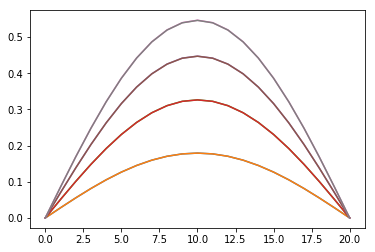

In [64]:
i = 0
for i in range(20, 100, 20):
    plt.plot(explicitSolution[i])
    plt.plot(exactSolution[i])
    i += 1

### 3 Порядок аппроксимации

In [66]:
diff = []

for i in range(len(exactSolution)):
    diff.append(max(abs(exactSolution[i] - explicitSolution[i])))

In [27]:
max(diff)/(h**2)

0.825989412202721

In [28]:
h

0.1

In [29]:
dt

0.005

In [30]:
max(diff)/(dt**2)

330.39576488108844

In [32]:
max(diff)

0.008259894122027212

In [67]:
max(diff)

0.0020575088732677216

### 4 Классический метод Рунге–Кутты четвертого порядка аппроксимации

Метод:

$$
\begin{aligned}
f_1 =& f(t_n, y_n)\\
f_2 =& f\left(t_n + \cfrac{dt}2, y_n + \cfrac{dt}{2}f_1 \right)\\
f_3 =& f\left(t_n + \cfrac{dt}2, y_n + \cfrac{dt}{2}f_2 \right)\\
f_4 =& f\left(t_n + dt, y_n + dtf_3 \right)\\
y_{n+1} =& y_n + \cfrac{dt}{6}\left(f_1 + 2f_2 + 2f_3 + f_4\right)
\end{aligned}
$$

In [15]:
def classic(f, y0, interval, dt):
    y = [y0]
    t = interval[0]
    
    while t + dt < interval[1]:
        f_1 = f(y[-1])
        f_2 = f(y[-1]+dt/2*f_1)
        f_3 = f(y[-1]+dt/2*f_2)
        f_4 = f(y[-1]+dt*f_3)
        y_next = y[-1]+dt/6*(f_1+2*f_2+2*f_3+f_4)
        y.append(y_next)
        t += dt
        
    return y

In [16]:
classicSolution = classic(f=F, y0=[0]*(m-2), interval=[0,1], dt=dt)

In [17]:
for i in range(len(classicSolution)):
    classicSolution[i] = np.insert(classicSolution[i], 0, 0)
    classicSolution[i] = np.append(classicSolution[i], 0)
    
classicSolution = np.array(classicSolution)

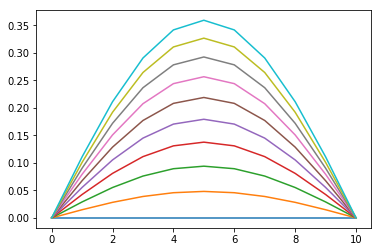

In [18]:
i = 0
for i in range(10):
    plt.plot(classicSolution[i])
    i += 1

### 5 Порядок аппроксимации

In [19]:
diff_c = []

for i in range(len(exactSolution)):
    diff_c.append(max(abs(exactSolution[i] - classicSolution[i])))
    
max(diff_c)/((dt**4)**2+(h**2)**2)**(0.5)

0.8260144897438518